In [4]:
from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive.zip


In [5]:
!ls


archive.zip  sample_data


In [6]:
!unzip archive.zip


Streaming output truncated to the last 5000 lines.
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_124.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_125.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_126.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_127.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_128.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_129.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_130.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_131.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_132.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_133.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_134.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_135.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_136.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_137.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_138.jpg  
  inflating: input/

In [7]:
!ls


archive.zip  input  sample_data


In [8]:
!ls input


'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


In [9]:
!pip install numpy opencv-python scikit-image scikit-learn matplotlib minisom


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=01b27143a2be32cfc33a4dff2a43735ed66f7b44ea4c4ceddac8b6756e5f922d
  Stored in directory: /root/.cache/pip/wheels/0f/8c/a4/5b7aa56fa6ef11d536d45da775bcc5a2a1c163ff0f8f11990b
Successfully built minisom


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from minisom import MiniSom
from sklearn.cluster import KMeans
from skimage.feature import graycomatrix, graycoprops

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


In [11]:
DATASET_PATH = "/content/input"

LABELS = {
    "Non Demented": 0,
    "Very mild Dementia": 1,
    "Mild Dementia": 2,
    "Moderate Dementia": 2
}

CLASS_NAMES = ["Non Demented", "Very Mild", "Mild/Moderate"]

In [12]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, 0)
    img = cv2.resize(img, (256, 256))
    img = cv2.medianBlur(img, 5)

    # Simple skull stripping
    _, thresh = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5,5), np.uint8)
    brain = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    return brain


In [13]:
def amsom_kmeans_segmentation(image):
    pixels = image.reshape(-1, 1).astype(np.float32)
    nonzero = pixels[pixels > 0]

    if len(np.unique(nonzero)) < 3:
        kmeans = KMeans(n_clusters=2, random_state=42)
        labels = kmeans.fit_predict(pixels)
        return labels.reshape(256, 256)

    som = MiniSom(8, 8, 1, sigma=1.0, learning_rate=0.5, random_seed=42)
    som.random_weights_init(nonzero)
    som.train_random(nonzero, 100)

    som_weights = som.get_weights().reshape(-1, 1)

    kmeans = KMeans(n_clusters=3, init=som_weights[:3], n_init=1, random_state=42)
    labels = kmeans.fit_predict(pixels)

    return labels.reshape(256, 256)


In [14]:

def extract_glcm_features(image):
    image = image.astype(np.uint8)

    glcm = graycomatrix(
        image,
        distances=[1],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=256,
        symmetric=True,
        normed=True
    )

    features = []
    for prop in ['contrast', 'energy', 'homogeneity', 'correlation', 'ASM', 'dissimilarity']:
        features.append(graycoprops(glcm, prop).mean())

    return features


def extract_volume_features(image):
    total = image.size
    nonzero = np.count_nonzero(image)

    return [
        nonzero / total,
        np.mean(image[image > 0]),
        np.std(image[image > 0])
    ]


In [15]:
def extract_extra_features(image):
    ent = entropy(image, disk(5)).mean()

    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    grad = np.mean(np.sqrt(gx**2 + gy**2))

    return [ent, grad]


In [16]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
features = []
labels = []
patient_ids = []

for class_name, label in LABELS.items():
    folder = os.path.join(DATASET_PATH, class_name)

    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)

        # 🔑 patient ID from filename (edit if needed)
        patient_id = file.split("_")[0]

        img = preprocess_image(img_path)

        feat = (
            extract_glcm_features(img)
            + extract_volume_features(img)
            + extract_extra_features(img)
        )

        features.append(feat)
        labels.append(label)
        patient_ids.append(patient_id)

X = np.array(features)
y = np.array(labels)
patient_ids = np.array(patient_ids)

print("Samples:", X.shape[0])
print("Feature size:", X.shape[1])


Samples: 9488
Feature size: 11


In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("Reduced feature size:", X_pca.shape[1])


Reduced feature size: 3


In [18]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_pca,
    y,
    np.arange(len(y)),
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [19]:
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='rbf', C=1, gamma='scale'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB()
}



========== KNN ==========
Accuracy: 0.6227608008429927
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       600
           1       0.58      0.57      0.58       600
           2       0.66      0.61      0.64       698

    accuracy                           0.62      1898
   macro avg       0.62      0.62      0.62      1898
weighted avg       0.62      0.62      0.62      1898



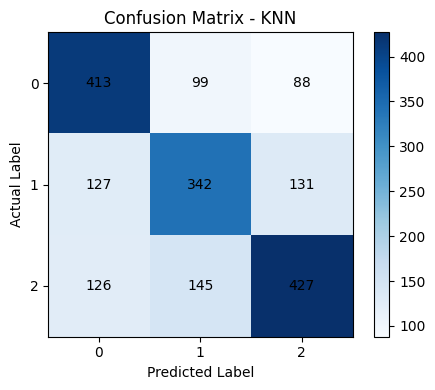


========== SVM ==========
Accuracy: 0.6232876712328768
              precision    recall  f1-score   support

           0       0.60      0.71      0.65       600
           1       0.61      0.49      0.54       600
           2       0.65      0.66      0.66       698

    accuracy                           0.62      1898
   macro avg       0.62      0.62      0.62      1898
weighted avg       0.62      0.62      0.62      1898



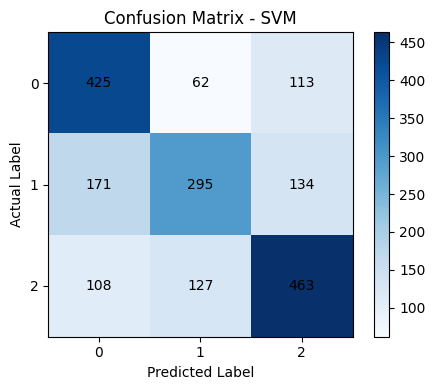


========== Decision Tree ==========
Accuracy: 0.5827186512118019
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       600
           1       0.55      0.55      0.55       600
           2       0.60      0.58      0.59       698

    accuracy                           0.58      1898
   macro avg       0.58      0.58      0.58      1898
weighted avg       0.58      0.58      0.58      1898



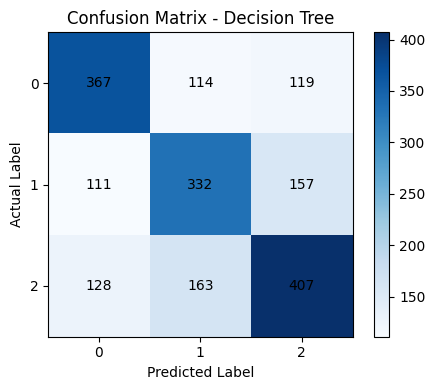


========== Random Forest ==========
Accuracy: 0.6375131717597471
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       600
           1       0.62      0.58      0.60       600
           2       0.64      0.68      0.66       698

    accuracy                           0.64      1898
   macro avg       0.64      0.64      0.64      1898
weighted avg       0.64      0.64      0.64      1898



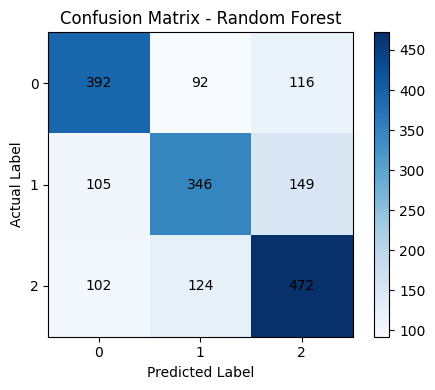


========== Naive Bayes ==========
Accuracy: 0.553213909378293
              precision    recall  f1-score   support

           0       0.56      0.58      0.57       600
           1       0.57      0.28      0.38       600
           2       0.54      0.76      0.63       698

    accuracy                           0.55      1898
   macro avg       0.56      0.54      0.53      1898
weighted avg       0.56      0.55      0.53      1898



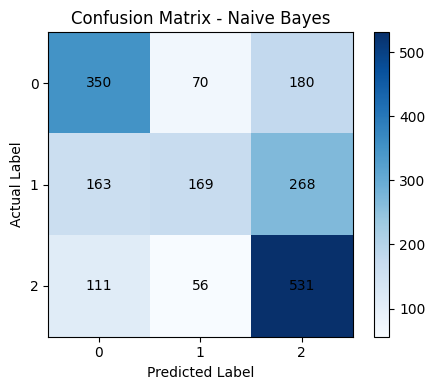

In [20]:
results = {}

for name, model in classifiers.items():
    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n========== {name} ==========")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.colorbar()

    # ✅ FIX: dynamic labels (works for 2/3/4 classes)
    classes = np.unique(y_test)
    ticks = range(len(classes))

    plt.xticks(ticks, classes)
    plt.yticks(ticks, classes)

    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")

    # Add values inside cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()


In [21]:
!pip install xgboost

In [22]:
from xgboost import XGBClassifier


In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=8,
    min_child_weight=2,
    subsample=0.85,
    colsample_bytree=0.85,
    gamma=0.3,
    reg_alpha=0.5,
    reg_lambda=1.5,
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42
)

xgb.fit(X_train, y_train)
slice_preds = xgb.predict(X_test)

print("\n========== XGBoost ==========")
print("Accuracy:", accuracy_score(y_test, slice_preds))
print(classification_report(y_test, slice_preds, zero_division=0))



========== XGBoost ==========
Accuracy: 0.6564805057955743
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       600
           1       0.63      0.58      0.60       600
           2       0.65      0.72      0.68       698

    accuracy                           0.66      1898
   macro avg       0.66      0.65      0.65      1898
weighted avg       0.66      0.66      0.66      1898



In [25]:
from collections import defaultdict

patient_pred_dict = defaultdict(list)
patient_true_dict = {}

for pid, pred, true in zip(
        patient_ids[idx_test],
        slice_preds,
        y_test):
    patient_pred_dict[pid].append(pred)
    patient_true_dict[pid] = true

final_preds = []
final_true = []

for pid in patient_pred_dict:
    final_preds.append(np.bincount(patient_pred_dict[pid]).argmax())
    final_true.append(patient_true_dict[pid])


In [26]:
print("PATIENT-LEVEL ACCURACY:",
      accuracy_score(final_true, final_preds))

print("\nPATIENT-LEVEL CLASSIFICATION REPORT:\n")
print(classification_report(
    final_true,
    final_preds,
    zero_division=0
))


PATIENT-LEVEL ACCURACY: 1.0

PATIENT-LEVEL CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           2       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [27]:
unique_labels = np.unique(final_true)

print(classification_report(
    final_true,
    final_preds,
    labels=unique_labels,
    target_names=[CLASS_NAMES[i] for i in unique_labels],
    zero_division=0
))


               precision    recall  f1-score   support

Mild/Moderate       1.00      1.00      1.00         1

     accuracy                           1.00         1
    macro avg       1.00      1.00      1.00         1
 weighted avg       1.00      1.00      1.00         1



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


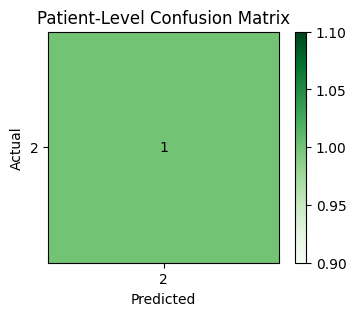

In [28]:
from sklearn.metrics import confusion_matrix

cm_patient = confusion_matrix(final_true, final_preds)

plt.figure(figsize=(4,3))
plt.imshow(cm_patient, cmap="Greens")
plt.title("Patient-Level Confusion Matrix")
plt.colorbar()

ticks = np.unique(final_true)
plt.xticks(range(len(ticks)), ticks)
plt.yticks(range(len(ticks)), ticks)

for i in range(cm_patient.shape[0]):
    for j in range(cm_patient.shape[1]):
        plt.text(j, i, cm_patient[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


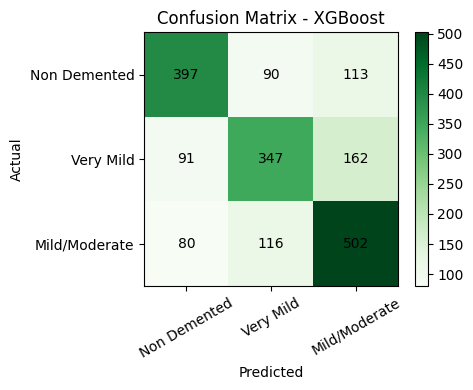

In [32]:
cm = confusion_matrix(y_test, slice_preds)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Greens")
plt.title("Confusion Matrix - XGBoost")
plt.colorbar()

plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES, rotation=30)
plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [33]:
from sklearn.metrics import accuracy_score

xgb_acc = accuracy_score(y_test, slice_preds)

results["XGBoost"] = xgb_acc


In [34]:
print("\n===== FINAL CLASSIFIER COMPARISON =====")
for clf, acc in results.items():
    print(f"{clf}: {acc:.4f}")



===== FINAL CLASSIFIER COMPARISON =====
KNN: 0.6228
SVM: 0.6233
Decision Tree: 0.5827
Random Forest: 0.6375
Naive Bayes: 0.5532
XGBoost: 0.6565


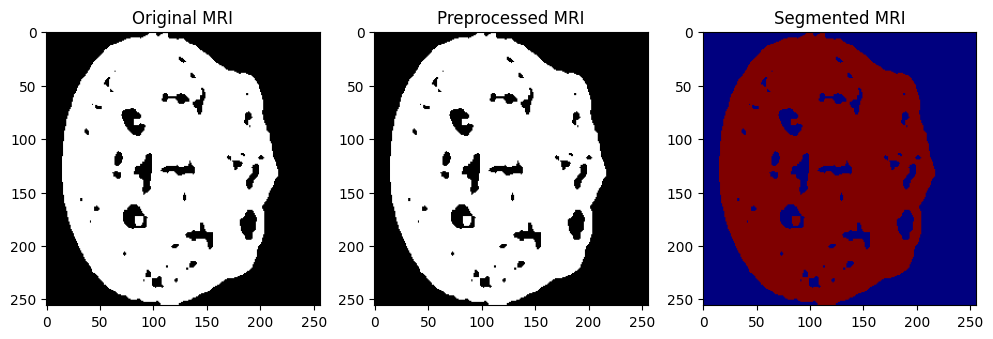

In [36]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original MRI")
plt.imshow(img, cmap='gray')

plt.subplot(1,3,2)
plt.title("Preprocessed MRI")
plt.imshow(preprocess_image(img_path), cmap='gray')

plt.subplot(1,3,3)
plt.title("Segmented MRI")
plt.imshow(img, cmap='jet')

plt.show()


In [37]:
print("Total images used:", X.shape[0])
print("Training images:", X_train.shape[0])
print("Testing images:", X_test.shape[0])


Total images used: 9488
Training images: 7590
Testing images: 1898


In [38]:
import numpy as np
from collections import Counter

# Count per class in training data
train_counts = Counter(y_train)

# Count per class in testing data
test_counts = Counter(y_test)

print("Class-wise Training Images:")
for class_name, label in LABELS.items():
    print(f"{class_name}: {train_counts[label]}")

print("\nClass-wise Testing Images:")
for class_name, label in LABELS.items():
    print(f"{class_name}: {test_counts[label]}")


Class-wise Training Images:
Non Demented: 2400
Very mild Dementia: 2400
Mild Dementia: 2790
Moderate Dementia: 2790

Class-wise Testing Images:
Non Demented: 600
Very mild Dementia: 600
Mild Dementia: 698
Moderate Dementia: 698


In [41]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
classifiers["XGBoost"] = xgb_model


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:14:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


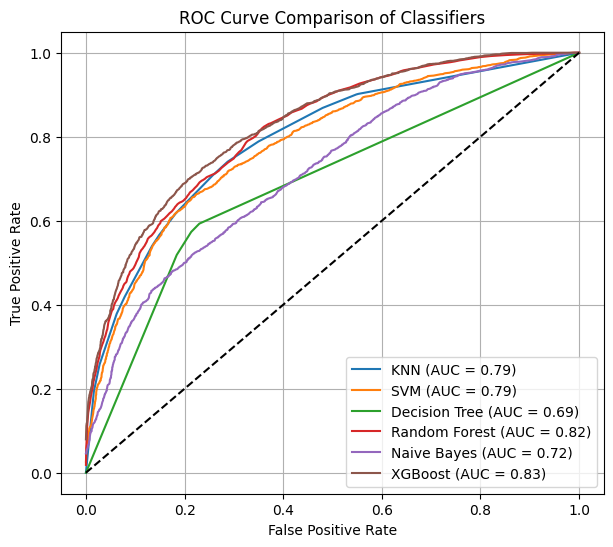

In [42]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))

# 🔹 determine number of classes dynamically
classes = np.unique(y_test)
n_classes = len(classes)

# Binarize labels correctly
y_test_bin = label_binarize(y_test, classes=classes)

for name, model in classifiers.items():

    # Train model
    model.fit(X_train, y_train)

    # Get probability scores
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        from sklearn.svm import SVC
        svm_model = SVC(kernel='rbf', probability=True)
        svm_model.fit(X_train, y_train)
        y_score = svm_model.predict_proba(X_test)

    # Compute macro-average ROC
    fpr = {}
    tpr = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])

    # Aggregate all FPRs
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    roc_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Diagonal line
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Classifiers")
plt.legend(loc="lower right")
plt.grid()
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:15:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


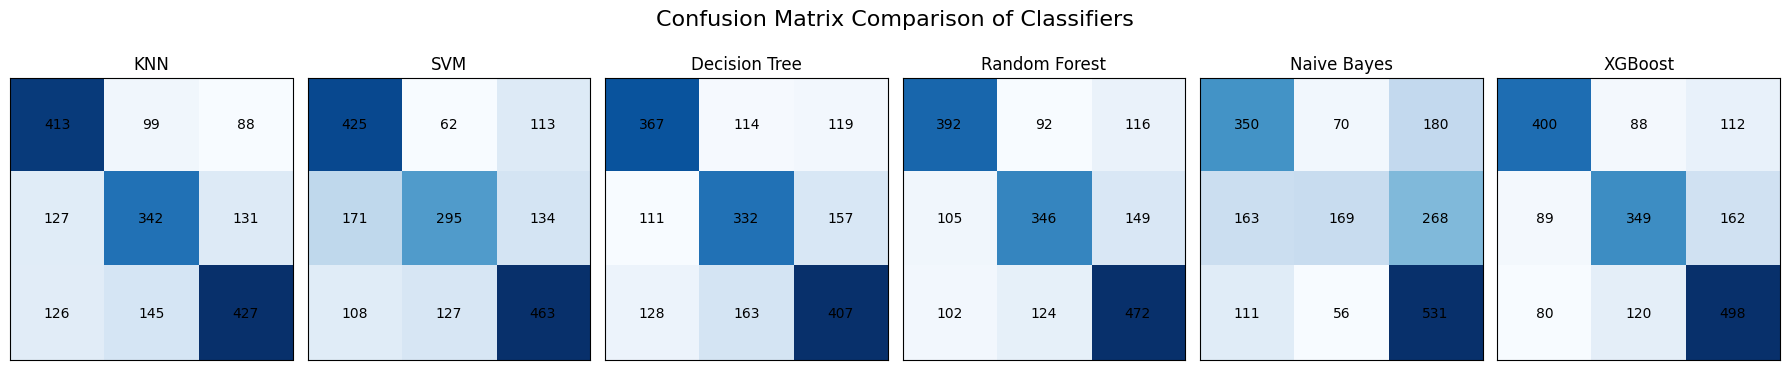

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(18, 4))

for idx, (name, model) in enumerate(classifiers.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(1, len(classifiers), idx + 1)
    plt.imshow(cm, cmap="Blues")
    plt.title(name)

    plt.xticks([])
    plt.yticks([])

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center", color="black", fontsize=10)

plt.suptitle("Confusion Matrix Comparison of Classifiers", fontsize=16)
plt.tight_layout()
plt.show()
